In [1]:
# -*- coding: utf-8 -*-
import re
import time
import datetime 
import operator
import numpy as np
import pandas as pd 
import collections
import unicodedata
import collections
import seaborn as sns
import collections
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt

from tqdm import tqdm
from collections import Counter
from datetime import datetime, date, timedelta
from IPython.display import Image


%matplotlib inline

pylab.rcParams['figure.figsize'] = 10,8

plt.style.use('bmh')
colors = ['#348ABD', '#A60628', '#7A68A6', '#467821', '#D55E00', 
          '#CC79A7', '#56B4E9', '#009E73', '#F0E442', '#0072B2']

In [2]:
reward_table = [
    [ -250 , -15000, -405 , -15000],
    [-309 , -15000, -400 , 405  ],
    [-262 , -15000, -255 , 400  ],
    [-231 , -15000, -77  , 255  ],
    [-61  , -15000, 0    , 77   ],
    [0    , -15000, 0    , 0    ],
    [0    , -15000, -15000, 0    ],
    [-325 , 250  , -452 , -15000],
    [-270 , 309  , -325 , 452  ],
    [-200 , 262  , -190 , 325  ],
    [-125 , 231  , -10  , 190  ],
    [-2   , 61   , 0    , 10   ],
    [0    , 0    , 0    , 0    ],
    [0    , 0    , -15000, 0    ],
    [-192 , 325  , -390 , -15000],
    [-169 , 270  , -285 , -390 ],
    [-105 , 200  , -132 , 285  ],
    [-10  , 125  , -5   , 132  ],
    [0    , 2    , 0    , 5    ],
    [0    , 0    , 0    , 0    ],
    [0    , 0    , -15000, 0    ],
    [-117 , 192  , -350 , -15000],
    [-67  , 169  , -235 , 350  ],
    [-8   , 105  , -26  , 235  ],
    [0    , 10   , 0    , 26   ],
    [0    , 0    , 0    , 0    ],
    [0    , 0    , 0    , 0    ],
    [0    , 0    , -15000, 0    ],
    [-38  , 117  , -250 , -15000],
    [0    , 67   , -148 , 250  ],
    [0    , 8    , -3   , 148  ],
    [0    , 0    , 0    , 3    ],
    [0    , 0    , 0    , 0    ],
    [0    , 0    , 0    , 0    ],
    [0    , 0    , -15000, 0    ],
    [0    , 38   , -195 , -15000],
    [0    , 0    , -193 , 195  ],
    [0    , 0    , -5   , 193  ],
    [0    , 0    , 0    , 5    ],
    [0    , 0    , 0    , 0    ],
    [0    , 0    , 0    , 0    ],
    [0    , 0    , -15000, 0    ],
    [-15000, 0    , -255 , -15000],
    [-15000, 0    , -190 , 255  ],
    [-15000, 0    , -8   , 190  ],
    [-15000, 0    , 0    , 8   ],
    [-15000, 0    , 0    , 0    ],
    [-15000, 0    , 0    , 0    ],
    [-15000, 0    , -15000, 0    ]
]; 

In [3]:
def softmax(f):
    f = f - np.max(f)
    p = np.exp(f) / np.sum(np.exp(f))
    return p

In [4]:
softmax_reward_table = np.apply_along_axis(softmax, 1, reward_table)

In [5]:
def action_is_allowed(learner, state, action):

    if (action == 0 and not(state > learner.num_states - learner.servo_num_states - 1)):
        return True
    elif (action == 1 and not(state < learner.servo_num_states)):
        return True
    elif (action == 2 and not((state%learner.servo_num_states) == (learner.servo_num_states-1))):
        return True
    elif (action == 3 and not(state%learner.servo_num_states==0)):
        return True
    else:
        return False

In [6]:
class QLearner(object):
    def __init__(self, 
                 servo_num_states, 
                 num_actions, 
                 alpha, 
                 gamma, 
                 random_action_rate,
                 random_action_decay_rate, 
                 warm_up_period, 
                 action_penalty,
                 negative_reward_coef,
                 interest_zone_reward_coef,
                 initial_state,
                 scaling_point, 
                 scaling_factor):
        
        self.servo_num_states = servo_num_states
        self.num_states = servo_num_states**2
        self.num_actions = num_actions
        self.alpha = alpha
        self.gamma = gamma
        self.random_action_rate = random_action_rate
        self.random_action_decay_rate = random_action_decay_rate
        self.warm_up_period = warm_up_period
        self.state = initial_state
        self.action = 0
        self.action_penalty = action_penalty
#         self.qtable = np.random.uniform(low=-1, high=1, size=(self.num_states, self.num_actions))
#         self.qtable = np.zeros((self.num_states, self.num_actions))
        self.qtable = np.ones((self.num_states, self.num_actions)) * 0
        self.num_iteration = 0
        self.last_reward = 0
        self.negative_reward_coef = negative_reward_coef
        self.interest_zone_reward_coef = interest_zone_reward_coef
        self.scaling_point = scaling_point
        self.scaling_factor = scaling_factor
        
    def set_initial_state(self, action):
        """
        @summary: Sets the initial state and returns an action
        @param state: The initial state
        @returns: The selected action
        """
        self.state = int(self.num_states/2)
        self.action = action #self.qtable[state].argsort()[-1]
        
    def get_next_state(self):
        
        next_state = None
        
        if (self.action == 0 and action_is_allowed(self, self.state, self.action)): 
            next_state = self.state + self.servo_num_states
        elif (self.action == 1 and action_is_allowed(self, self.state, self.action)):
            next_state = self.state - self.servo_num_states
        elif (self.action == 2 and action_is_allowed(self, self.state, self.action)):
            next_state = self.state + 1
        elif (self.action == 3 and action_is_allowed(self, self.state, self.action)):
            next_state = self.state - 1 
        else:
            next_state = self.state;
            
        return next_state
        
    def move(self, state_prime, reward):
        """
        @summary: Moves to the given state with given reward and returns action
        @param state_prime: The new state
        @param reward: The reward
        @returns: The selected action
        """
        alpha = self.alpha
        gamma = self.gamma
        state = self.state
        action = self.action
        qtable = self.qtable
        action_prime = -1
        
#         if self.state == state_prime: 

#             while not self.action_is_allowed(action_prime):
#                 action_prime = np.random.randint(0, self.num_actions)
            
#             self.action = action_prime
            
        if False:
            print 'yo'
            
        else: 
            
            choose_random_action = (1 - self.random_action_rate) <= np.random.uniform(0, 1)

            if choose_random_action:
#                 while not(action_is_allowed(self, state_prime, action_prime)): 
                action_prime = np.random.randint(0, self.num_actions)
            else:
                ordered_action_list = self.qtable[state_prime].argsort()
                best_choice_index = -1
#                 while not(action_is_allowed(self, state_prime, action_prime)):
                action_prime = ordered_action_list[best_choice_index]
#                     best_choice_index -= 1

            if self.num_iteration > self.warm_up_period: # warm up period is over
                self.random_action_rate *= self.random_action_decay_rate
                    
            
#             if reward < 0 and np.abs(reward) < 15000:
#                 reward = reward * self.negative_reward_coef
            
#             if self.num_iteration % 50 == 0:
#                 qtable *= self.scaling_factor
                
            
            qtable[state, action] = qtable[state, action] + alpha * (reward + gamma * qtable[state_prime, action_prime] - qtable[state, action])

            self.state = state_prime
            self.action = action_prime    
            self.qtable = qtable

In [124]:
def get_final_reward(learner, reward_table, training_iteration):
    
    reward_list = []
    
    learned_reward_table = np.zeros((learner.num_states, learner.num_actions))
    
    num_exploration_step = 1000
    
    verbose = True
    
    for iteration_step in xrange(training_iteration):

#         reward = reward_table[learner.state][learner.action] - learner.action_penalty

#         if learner.state % learner.servo_num_states > 2 and learner.state < 30:
#             reward = reward * learner.interest_zone_reward_coef if reward > 0 else reward
            
        if iteration_step < num_exploration_step: 
            
            ideal_reward = reward_table[learner.state][learner.action] 
            random_noise = np.random.normal(0, np.abs(ideal_reward)*.25) if ideal_reward != 0 else 0 
            noisy_reward = ideal_reward + random_noise - learner.action_penalty

            if learner.state % learner.servo_num_states > 2 and learner.state < 30:
                reward = noisy_reward * learner.interest_zone_reward_coef if noisy_reward > 0 else noisy_reward * learner.negative_reward_coef
            else:
                reward = noisy_reward

            if learned_reward_table[learner.state][learner.action] != 0:
                learned_reward_table[learner.state][learner.action] = .5*(learned_reward_table[learner.state][learner.action] + reward)
            else:
                learned_reward_table[learner.state][learner.action] = noisy_reward


            next_state = learner.get_next_state()

            learner.move(next_state, learned_reward_table[learner.state][learner.action])

            learner.num_iteration += 1 

            if learner.num_iteration % learner.scaling_point == 0: learner.qtable *= learner.scaling_factor

            reward_list.append(learned_reward_table[learner.state][learner.action])
        
        else:
            
#             if verbose:
#                 print "Begin simulation"
                
#             verbose = False
            
            reward = learned_reward_table[learner.state][learner.action]
            reward_list.append(learned_reward_table[learner.state][learner.action])


            next_state = learner.get_next_state()
            learner.move(next_state, learned_reward_table[learner.state][learner.action])
            learner.num_iteration += 1 

            if learner.num_iteration % learner.scaling_point == 0: 
                learner.qtable *= learner.scaling_factor
        
    return np.mean(reward_list)
    
    

In [127]:
from hyperopt import hp, fmin, tpe, hp, STATUS_OK, Trials
import datetime

best_score = np.inf

def score(params):
    
    global best_score    
    
    num_iteration = 2
    
    loss_vector = []
    
    for i in xrange(num_iteration):
    
        learner = QLearner(servo_num_states = 7,
                           num_actions=4,
                           alpha=float(params['alpha']),
                           gamma=float(params['gamma']),
                           random_action_rate=float(params['random_action_rate']),
                           random_action_decay_rate=float(params['random_action_decay_rate']),
                           warm_up_period=int(params['warm_up_period']),
                           action_penalty=50,
                           negative_reward_coef=1, #float(params['negative_reward_coef']),
                           interest_zone_reward_coef = 1, #float(params['interest_zone_reward_coef']),
                           initial_state=10,
                           scaling_point = int(params['scaling_point']),
                           scaling_factor = float(params['scaling_factor']))#int(params['initial_state'])) #float(params['action_penalty']))
        #learner.set_initial_state(action=0)

        temp_loss = - get_final_reward(learner, reward_table, training_iteration=50000) # negative because we want to minimize loss
        loss_vector.append(temp_loss)
        
    loss = np.mean(loss_vector)
    
    if loss < best_score: 
        print "Searching...", 
        print "New best score: {0:.6f}".format(-loss), 
        print params 
        print datetime.datetime.now().time()
        print
        best_score = loss

    return {'loss': loss, 'status': STATUS_OK}
    
def optimize(trials):
        
    space = {
             'alpha': hp.uniform('alpha', 0.1, 1),
             'gamma': hp.uniform('gamma', 0.1, 1),
             'random_action_rate': hp.uniform('random_action_rate', 0.8,1), 
             'random_action_decay_rate': hp.uniform('random_action_decay_rate', 0.1, 1),
             'warm_up_period': hp.quniform('warm_up_period', 50, 300, 10),
             'scaling_point': hp.choice('scaling_point', np.arange(5,300, 5)),
             'scaling_factor': hp.uniform('scaling_factor', 1., 5.)
#              'initial_state': hp.quniform('initial_state', 0, 47, 1)
#              'negative_reward_coef': hp.uniform('negative_reward_coef', 1, 1.5),
#              'interest_zone_reward_coef': hp.uniform('interest_zone_reward_coef', 1, 1.5)
            }

    best = fmin(score, space, algo=tpe.suggest, trials=trials, max_evals=400)

    print '------------------------' 
    print "Done."
    print "Best parameter setting:", best
    return best

In [128]:
%%time

#Trials object where the history of search will be stored
trials = Trials()

best_params = optimize(trials)

Searching... New best score: -35.352493 {'warm_up_period': 260.0, 'random_action_decay_rate': 0.142426083737119, 'scaling_factor': 1.3220198858172334, 'alpha': 0.5504661437202416, 'scaling_point': 170, 'gamma': 0.9457926799722469, 'random_action_rate': 0.8809362474632062}
16:43:42.255444

Searching... New best score: -9.286013 {'warm_up_period': 210.0, 'random_action_decay_rate': 0.632120451193053, 'scaling_factor': 1.0814874299050259, 'alpha': 0.5576989281907332, 'scaling_point': 100, 'gamma': 0.2505316293729903, 'random_action_rate': 0.8679148899000352}
16:43:52.237360

Searching... New best score: -7.930535 {'warm_up_period': 190.0, 'random_action_decay_rate': 0.5892996273746175, 'scaling_factor': 2.472819039005773, 'alpha': 0.7138669068673575, 'scaling_point': 255, 'gamma': 0.6701417050510539, 'random_action_rate': 0.842782858471514}
16:44:43.994269

Searching... New best score: 7.297269 {'warm_up_period': 60.0, 'random_action_decay_rate': 0.1835397681253017, 'scaling_factor': 2.97

In [9]:
def get_next_state_temp(learner, state, action):
    
    next_state = None

    if (action == 0 and action_is_allowed(learner, state, action)): 
        next_state = state + learner.servo_num_states
    elif (action == 1 and action_is_allowed(learner, state, action)):
        next_state = state - learner.servo_num_states
    elif (action == 2 and action_is_allowed(learner, state, action)):
        next_state = state + 1
    elif (action == 3 and action_is_allowed(learner, state, action)):
        next_state = state - 1 
    else:
        next_state = state;

    return next_state

In [364]:
reward_bins = pd.cut([-800, 800], bins=500, retbins=True)[1][1:-1]

In [365]:
def to_bin(value, bins):
        return np.digitize(x=[value], bins=bins)[0]

100%|██████████| 2/2 [00:00<00:00, 13.97it/s]


27
26
27
26
27
26
27
26
27
26
27
26
27
26
27
26
27
26
27
26
27
26
27
26
27
26
27
26
27

Reward per action:  46.60825


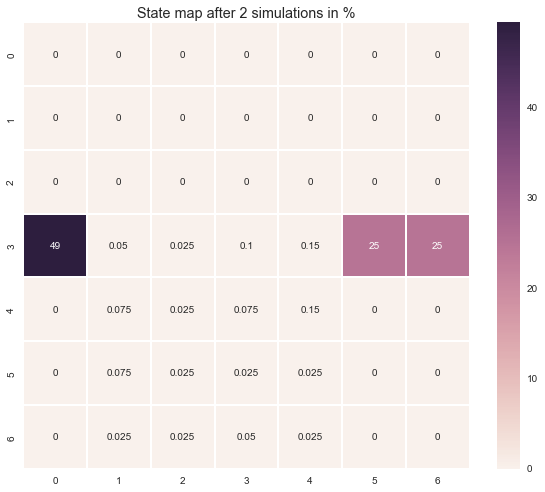

In [367]:
def crawling_simulation(params, reward_table, training_iteration = 2000, num_simulation = 2):
    
    state_vector = np.zeros(49)
    action_vector = np.zeros(4)
    reward_vector = []
    reward_bins = pd.cut([-800, 800], bins=200, retbins=True)[1][1:-1]

    for simulation in tqdm(xrange(num_simulation)):
        
        temp_reward = []

        learner = QLearner(servo_num_states = 7,
                   num_actions=4,
                   alpha=float(params['alpha']),
                   gamma=float(params['gamma']),
                   random_action_rate=float(params['random_action_rate']),
                   random_action_decay_rate=float(params['random_action_decay_rate']),
                   warm_up_period=int(params['warm_up_period']),
                   action_penalty=50,
                   negative_reward_coef=1.,#float(params['negative_reward_coef']),
                   interest_zone_reward_coef = 1, #1.32, #float(params['interest_zone_reward_coef']),
                   initial_state=24,
                   scaling_point = params['scaling_point'],
                   scaling_factor = params['scaling_factor'])#int(params['initial_state'])) #float(params['action_penalty']))

        learned_reward_table = np.zeros((learner.num_states, learner.num_actions))
    
        for iteration_step in xrange(training_iteration):
            
            state_vector[learner.state] += 1
            action_vector[learner.action] += 1 
    
            if iteration_step > training_iteration-30 and simulation == num_simulation-1:
                print learner.state 
#                 print reward_table[1]
#                 print learned_reward_table[1]
               
    
#             if iteration_step % 500 == 0:
#                 print np.mean(np.abs(learned_reward_table - reward_table))
            
            
    
            ideal_reward = reward_table[learner.state][learner.action] 
            random_noise = np.random.normal(0, np.abs(ideal_reward)*.25) if ideal_reward != 0 else 0 
            noisy_reward = ideal_reward + random_noise - learner.action_penalty
            
            
            if learner.state % learner.servo_num_states > 2 and learner.state < 30:
                noisy_reward = noisy_reward * learner.interest_zone_reward_coef if noisy_reward > 0 else noisy_reward * learner.negative_reward_coef
                  
    
#             noisy_reward = to_bin(noisy_reward, reward_bins)
            
            temp_bin_value = .5*(reward_bins[learned_reward_table[learner.state][learner.action]] + noisy_reward)

            learned_reward_table[learner.state][learner.action] = to_bin(temp_bin_value, reward_bins)
#             print noisy_reward
            
#             if learned_reward_table[learner.state][learner.action] != 0:
#                 learned_reward_table[learner.state][learner.action] = .5*(learned_reward_table[learner.state][learner.action] + noisy_reward)
#             else:
#                 learned_reward_table[learner.state][learner.action] = noisy_reward
                
            
            
            temp_reward.append(learned_reward_table[learner.state][learner.action])
            
            next_state = learner.get_next_state()
            
            learner.move(next_state, learned_reward_table[learner.state][learner.action])
            
            learner.num_iteration += 1 
        
            if learner.num_iteration % learner.scaling_point == 0: 
                learner.qtable *= learner.scaling_factor
            
            
#             for s in xrange(0, learner.num_states):
#                 for a in xrange (0, learner.num_actions):
#                     if s != learner.state or a != learner.action:
                        
#                         next_state_temp = get_next_state_temp(learner, s, a)
                        
#                         temp_r = learned_reward_table[s][a] - learner.action_penalty
                        
#                         choose_random_action = (1 - learner.random_action_rate) <= np.random.uniform(0, 1)

#                         if choose_random_action:
#                             action_prime_temp = np.random.randint(0, learner.num_actions)
#                         else:
#                             action_prime_temp = learner.qtable[next_state_temp].argsort()[-1]


#                         learner.qtable[s, a] += learner.alpha * (temp_r + learner.gamma * learner.qtable[next_state_temp, action_prime_temp] - learner.qtable[s, a])
                    
            
    
        reward_vector.append(np.mean(temp_reward))
    
            
        
    normalize_state_vector = (state_vector/np.sum(state_vector)) * 100.
    state_map = pd.DataFrame(normalize_state_vector.reshape(learner.servo_num_states, -1))
    sns.heatmap(state_map, linewidths=1, annot=True)
    plt.title('State map after {} simulations in %'.format(num_simulation))
    
    normalize_action_vector = (action_vector/np.sum(action_vector)) * 100.
    
    #print len(reward_vector)
    print "\nReward per action: ",np.mean(reward_vector)
    #print normalize_action_vector
    
    return learner, learned_reward_table




best_params = {'warm_up_period': 44.0, 
               'scaling_factor': 1.0372293641209551, 
               'random_action_decay_rate': 0.5900692779721906, 
               'random_action_rate': 0.18634870253656852, 
               'alpha': 0.9764032895801622, 
               'scaling_point': 16, 
               'gamma': 0.964381829500279}

best_params = {'warm_up_period': 38.0, 
               'scaling_factor': 1.1130568801499376, 
               'random_action_decay_rate': 0.9505348646463121, 
               'random_action_rate': 0.19293344201527163, 
               'alpha': 0.7680484211161775, 
               'scaling_point': 300,
               'gamma': 0.9527683563414476}

best_params = {'warm_up_period': 38.0, 
               'scaling_factor': 1.1130568801499376, 
               'random_action_decay_rate': 0.9505348646463121, 
               'random_action_rate': 0.19293344201527163, 
               'alpha': 0.7680484211161775, 
               'scaling_point': 300, 
               'gamma': 0.9527683563414476}

best_params = {'warm_up_period': 15.0, 
               'scaling_factor': 1.1669767007065206, 
               'random_action_decay_rate': 0.283102086404449, 
               'random_action_rate': 0.3881361927595925, 
               'alpha': 0.7480711423078713, 
               'scaling_point': 155, 
               'gamma': 0.9846208655721159}

best_params = {'warm_up_period': 96.0, 
               'scaling_factor': 1.6944560688012607, 
               'random_action_decay_rate': 0.545267375797949, 
               'random_action_rate': 0.10056735562002306, 
               'alpha': 0.6227095466939823, 
               'scaling_point': 190, 
               'gamma': 0.932459803334474}

best_params =  {'warm_up_period': 14.0, 'scaling_factor': 1.1129161749445728, 'random_action_decay_rate': 0.6320229427611553, 'random_action_rate': 0.955872080367004, 'alpha': 0.6029734543946844, 'scaling_point': 30, 'gamma': 0.9565818726183515}

learner, learned_reward_table = crawling_simulation(best_params, reward_table)

In [333]:
reward_bins = pd.cut([-800, 800], bins=200, retbins=True)[1][1:-1]

reward_bins

array([-792., -784., -776., -768., -760., -752., -744., -736., -728.,
       -720., -712., -704., -696., -688., -680., -672., -664., -656.,
       -648., -640., -632., -624., -616., -608., -600., -592., -584.,
       -576., -568., -560., -552., -544., -536., -528., -520., -512.,
       -504., -496., -488., -480., -472., -464., -456., -448., -440.,
       -432., -424., -416., -408., -400., -392., -384., -376., -368.,
       -360., -352., -344., -336., -328., -320., -312., -304., -296.,
       -288., -280., -272., -264., -256., -248., -240., -232., -224.,
       -216., -208., -200., -192., -184., -176., -168., -160., -152.,
       -144., -136., -128., -120., -112., -104.,  -96.,  -88.,  -80.,
        -72.,  -64.,  -56.,  -48.,  -40.,  -32.,  -24.,  -16.,   -8.,
          0.,    8.,   16.,   24.,   32.,   40.,   48.,   56.,   64.,
         72.,   80.,   88.,   96.,  104.,  112.,  120.,  128.,  136.,
        144.,  152.,  160.,  168.,  176.,  184.,  192.,  200.,  208.,
        216.,  224.,

In [327]:
to_bin(150, reward_bins)

9

100%|██████████| 1/1 [00:01<00:00,  1.18s/it]

7
0
7
0
7
0
7
0
7
0
7
0
7
0
7
0
7
0
7
0
7
0
7
0
7
0
7
0
7

Reward per action:  -0.0008675


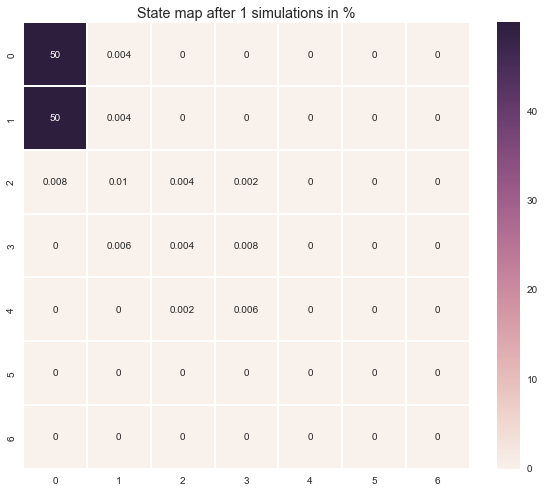

In [315]:
def crawling_simulation(params, reward_table, training_iteration = 50000, num_simulation = 1):
    
    state_vector = np.zeros(49)
    action_vector = np.zeros(4)
    reward_vector = []
    
    for simulation in tqdm(xrange(num_simulation)):
        
        temp_reward = []

        learner = QLearner(servo_num_states = 7,
                   num_actions=4,
                   alpha=float(params['alpha']),
                   gamma=float(params['gamma']),
                   random_action_rate=float(params['random_action_rate']),
                   random_action_decay_rate=float(params['random_action_decay_rate']),
                   warm_up_period=int(params['warm_up_period']),
                   action_penalty=50,
                   negative_reward_coef=1.,#float(params['negative_reward_coef']),
                   interest_zone_reward_coef = 1, #1.32, #float(params['interest_zone_reward_coef']),
                   initial_state=24,
                   scaling_point = params['scaling_point'],
                   scaling_factor = params['scaling_factor'])#int(params['initial_state'])) #float(params['action_penalty']))

        
        num_exploration_step = 50000
        
        learned_reward_table = np.zeros((learner.num_states, learner.num_actions))
    
        for iteration_step in xrange(training_iteration):
            
            state_vector[learner.state] += 1
            action_vector[learner.action] += 1 
    
            if iteration_step > training_iteration-30 and simulation == num_simulation-1:
                print learner.state 
            
            if iteration_step < num_exploration_step:
            
                ideal_reward = reward_table[learner.state][learner.action] 
                random_noise = np.random.normal(0, np.abs(ideal_reward)*.25) if ideal_reward != 0 else 0 
                noisy_reward = ideal_reward + random_noise - learner.action_penalty

                if learner.state % learner.servo_num_states > 2 and learner.state < 30:
                    reward = noisy_reward * learner.interest_zone_reward_coef if noisy_reward > 0 else noisy_reward * learner.negative_reward_coef
                else:
                    reward = noisy_reward

                if noisy_reward > 0:
                    noisy_reward = 1
                elif noisy_reward < 0:
                    noisy_reward = -1 
                    
#                 if learned_reward_table[learner.state][learner.action] != 0:
#                     learned_reward_table[learner.state][learner.action] = .5*(learned_reward_table[learner.state][learner.action] + noisy_reward)
#                 else:
#                     learned_reward_table[learner.state][learner.action] = noisy_reward


                learned_reward_table[learner.state][learner.action] = .5*(learned_reward_table[learner.state][learner.action] + noisy_reward)


                temp_reward.append(learned_reward_table[learner.state][learner.action])

                next_state = learner.get_next_state()

                learner.move(next_state, learned_reward_table[learner.state][learner.action])

                learner.num_iteration += 1 

                if learner.num_iteration % learner.scaling_point == 0: 
                    learner.qtable *= learner.scaling_factor

            else:
                
                reward = learned_reward_table[learner.state][learner.action]
                temp_reward.append(learned_reward_table[learner.state][learner.action])

                if noisy_reward >= 0:
                    noisy_reward = 1
                else: 
                    noisy_reward = -1 
                
                next_state = learner.get_next_state()
                learner.move(next_state, learned_reward_table[learner.state][learner.action])
                learner.num_iteration += 1 

                if learner.num_iteration % learner.scaling_point == 0: 
                    learner.qtable *= learner.scaling_factor
                
                    
        reward_vector.append(np.mean(temp_reward))
    
            
        
    normalize_state_vector = (state_vector/np.sum(state_vector)) * 100.
    state_map = pd.DataFrame(normalize_state_vector.reshape(learner.servo_num_states, -1))
    sns.heatmap(state_map, linewidths=1, annot=True)
    plt.title('State map after {} simulations in %'.format(num_simulation))
    
    normalize_action_vector = (action_vector/np.sum(action_vector)) * 100.
    
    #print len(reward_vector)
    print "\nReward per action: ",np.mean(reward_vector)
    #print normalize_action_vector
    
    return learner, learned_reward_table



best_params = {'warm_up_period': 96.0, 
               'scaling_factor': 1.6944560688012607, 
               'random_action_decay_rate': 0.545267375797949, 
               'random_action_rate': 0.10056735562002306, 
               'alpha': 0.6227095466939823, 
               'scaling_point': 190, 
               'gamma': 0.932459803334474}

best_params =   {'warm_up_period': 90.0, 
                 'scaling_factor': 3.6044006257743333, 
                 'random_action_decay_rate': 0.824709435216204, 
                 'random_action_rate': 0.834614308862227, 
                 'alpha': 0.3092353715331193, 
                 'scaling_point': 275, 
                 'gamma': 0.37419656297319936}

best_params =  {'warm_up_period': 14.0, 'scaling_factor': 1.1129161749445728, 'random_action_decay_rate': 0.6320229427611553, 'random_action_rate': 0.955872080367004, 'alpha': 0.6029734543946844, 'scaling_point': 30, 'gamma': 0.9565818726183515}


learner, learned_reward_table = crawling_simulation(best_params, reward_table)

In [318]:
learned_reward_table[:20]

array([[-1.  , -0.75, -0.75, -0.75],
       [ 0.  ,  0.  ,  0.  ,  0.75],
       [ 0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ],
       [-0.5 ,  1.  , -0.5 , -0.75],
       [ 0.  ,  0.  ,  0.  ,  0.75],
       [ 0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.5 , -0.5 , -0.75],
       [-0.75,  0.5 , -0.5 , -0.5 ],
       [-0.5 ,  0.  ,  0.  ,  0.5 ],
       [ 0.  ,  0.  ,  0.  ,  0.5 ],
       [ 0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ]])

In [207]:
reward_table[0]

[-250, -15000, -405, -15000]

In [195]:
np.mean(np.abs(learned_reward_table[0] - reward_table[0]))

1463.8918091224812

In [201]:
x = 3
for x in xrange(15):
    print np.abs(learned_reward_table[x] - reward_table[x])

[   79.81510783   702.65369531    81.77455242  4991.32388093]
[   56.99132307  2516.69572685    69.13761699    91.69393902]
[   73.60074697  3001.40237076    52.92744526    82.21528799]
[   231.          15000.             77.             64.74299803]
[    61.  15000.      0.     77.]
[     0.  15000.      0.      0.]
[     0.  15000.  15000.      0.]
[  149.10894403    43.5815364      4.25129222  2097.36118516]
[  63.95155894   87.03765296  170.47768212  102.63808143]
[ 200.            3.53525224   64.71355204   85.94717312]
[  90.37762556  231.           10.           44.14309636]
[  2.  61.   0.  10.]
[ 0.  0.  0.  0.]
[     0.      0.  15000.      0.]
[   66.44445243   135.58474784    45.79202003  4278.3198053 ]
